In [1]:
!python --version

Python 3.12.12


In [2]:
# Install dependencies
!pip install -q --upgrade numerapi pandas pyarrow matplotlib lightgbm scikit-learn scipy cloudpickle==3.1.1
!pip install -q --no-deps numerai-tools

# Inline plots
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 113.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 101.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [3]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# list the datasets and available versions
all_datasets = napi.list_datasets()
dataset_versions = list(set(d.split('/')[0] for d in all_datasets))
print("Available versions:\n", dataset_versions)

# Set data version to one of the latest datasets
DATA_VERSION = "v5.1"

# Print all files available for download for our version
current_version_files = [f for f in all_datasets if f.startswith(DATA_VERSION)]
print("Available", DATA_VERSION, "files:\n", current_version_files)

Available versions:
 ['v5.1', 'v5.0']
Available v5.1 files:
 ['v5.1/features.json', 'v5.1/live.parquet', 'v5.1/live_benchmark_models.parquet', 'v5.1/live_example_preds.csv', 'v5.1/live_example_preds.parquet', 'v5.1/meta_model.parquet', 'v5.1/train.parquet', 'v5.1/train_benchmark_models.parquet', 'v5.1/validation.parquet', 'v5.1/validation_benchmark_models.parquet', 'v5.1/validation_example_preds.csv', 'v5.1/validation_example_preds.parquet']


In [4]:
import json

# download the feature metadata file
napi.download_dataset(f"{DATA_VERSION}/features.json")

# read the metadata and display
feature_metadata = json.load(open(f"{DATA_VERSION}/features.json"))
for metadata in feature_metadata:
  print(metadata, len(feature_metadata[metadata]))

v5.1/features.json: 307kB [00:00, 1.25MB/s]                           

feature_sets 18
targets 37


### Feature Sets & Groups


In [5]:
feature_sets = feature_metadata["feature_sets"]
for feature_set in ["small", "medium", "all"]:
  print(feature_set, len(feature_sets[feature_set]))

small 42
medium 740
all 2562


In [6]:
import pandas as pd
import numpy as np

# scegliamo un set di feature più ricco
feature_set = feature_sets["medium"]   # puoi mettere "all" se hai molta RAM

# scegliamo i target da usare per il multi-target ensemble
all_targets = feature_metadata["targets"]
target_cols = []
if "target" in all_targets:
    target_cols.append("target")
# aggiungiamo altri tre target di supporto
target_cols += [t for t in all_targets if t != "target"][:3]

print("Useremo questi target:", target_cols)
print("Numero di feature:", len(feature_set))

# Scarica il train
napi.download_dataset(f"{DATA_VERSION}/train.parquet")

# Carica il train con tutte le feature + tutti i target scelti
train = pd.read_parquet(
    f"{DATA_VERSION}/train.parquet",
    columns=["era"] + target_cols + feature_set
)

# --- Memory helper: riduciamo un po' il dataset per non far esplodere Colab ---

import numpy as np

# 1) tieni solo le ultime MAX_ERAS ere (le più recenti)
MAX_ERAS = 350  # puoi alzare questo numero quando hai più potenza
unique_eras = np.sort(train["era"].unique())

if len(unique_eras) > MAX_ERAS:
    keep_eras = unique_eras[-MAX_ERAS:]
    train = train[train["era"].isin(keep_eras)].copy()
    print(f"Kept last {MAX_ERAS} eras -> {len(train)} rows")
else:
    print(f"Using all {len(unique_eras)} eras -> {len(train)} rows")

# 2) cast a float32 per risparmiare RAM
for col in feature_set:
    train[col] = train[col].astype("float32")
for t in target_cols:
    train[t] = train[t].astype("float32")

train.reset_index(drop=False, inplace=True)  # mantieni 'id' come colonna normale
train.set_index("id", inplace=True)
print("Train dtypes set to float32, shape:", train.shape)


Useremo questi target: ['target', 'target_agnes_20', 'target_agnes_60', 'target_alpha_20']
Numero di feature: 740


v5.1/train.parquet: 2.47GB [02:26, 16.8MB/s]                            


,era,target,target_agnes_20,target_agnes_60,target_alpha_20,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_accredited_consummate_currie,...,feature_working_jain_acromegaly,feature_wrapround_chrestomathic_timarau,feature_xanthic_transpadane_saleswoman,feature_xanthochroid_petrified_gutenberg,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,0.25,0.00,0.25,1,2,3,2,2,...,2,0,3,2,4,3,2,1,0,0
n003bba8a98662e4,0001,0.25,0.25,0.25,0.25,3,2,4,1,2,...,2,0,0,2,0,0,2,0,0,0
n003bee128c2fcfc,0001,0.75,1.00,1.00,1.00,1,2,0,2,2,...,2,3,3,2,2,3,2,2,2,4
n0048ac83aff7194,0001,0.25,0.25,0.25,0.25,1,2,3,4,2,...,2,0,2,1,1,4,2,0,2,1
n0055a2401ba6480,0001,0.25,0.25,0.50,0.25,3,2,3,4,2,...,2,1,3,3,2,4,2,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0.75,0.75,0.75,4,4,3,0,0,...,4,0,4,3,1,2,1,4,4,2
nffde3b371d67394,0574,0.25,0.50,0.75,0.25,4,4,3,0,0,...,3,0,4,0,2,2,2,1,3,3
nfff1a1111b35e84,0574,0.50,0.75,0.75,0.50,3,0,1,2,2,...,4,2,4,1,3,4,0,4,0,4



### Training data


In [7]:
train

,era,target,target_agnes_20,target_agnes_60,target_alpha_20,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_accredited_consummate_currie,...,feature_working_jain_acromegaly,feature_wrapround_chrestomathic_timarau,feature_xanthic_transpadane_saleswoman,feature_xanthochroid_petrified_gutenberg,feature_zincy_cirrhotic_josh,feature_zippy_trine_diffraction,feature_zonal_snuffly_chemism,feature_zygotic_middlebrow_caribbean,feature_zymolytic_intertidal_privet,feature_zymotic_windswept_cooky
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,0.25,0.00,0.25,1,2,3,2,2,...,2,0,3,2,4,3,2,1,0,0
n003bba8a98662e4,0001,0.25,0.25,0.25,0.25,3,2,4,1,2,...,2,0,0,2,0,0,2,0,0,0
n003bee128c2fcfc,0001,0.75,1.00,1.00,1.00,1,2,0,2,2,...,2,3,3,2,2,3,2,2,2,4
n0048ac83aff7194,0001,0.25,0.25,0.25,0.25,1,2,3,4,2,...,2,0,2,1,1,4,2,0,2,1
n0055a2401ba6480,0001,0.25,0.25,0.50,0.25,3,2,3,4,2,...,2,1,3,3,2,4,2,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nffcc1dbdf2212e6,0574,0.75,0.75,0.75,0.75,4,4,3,0,0,...,4,0,4,3,1,2,1,4,4,2
nffde3b371d67394,0574,0.25,0.50,0.75,0.25,4,4,3,0,0,...,3,0,4,0,2,2,2,1,3,3
nfff1a1111b35e84,0574,0.50,0.75,0.75,0.50,3,0,1,2,2,...,4,2,4,1,3,4,0,4,0,4


### Eras


<Axes: title={'center': 'Number of rows per era'}, xlabel='Era'>

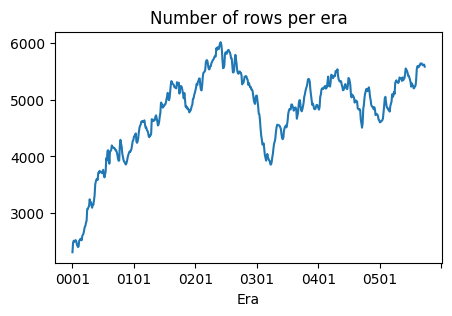

In [8]:
# Plot the number of rows per era
train.groupby("era").size().plot(
    title="Number of rows per era",
    figsize=(5, 3),
    xlabel="Era"
)

### Target


<Axes: title={'center': 'Target'}, xlabel='Value', ylabel='Frequency'>

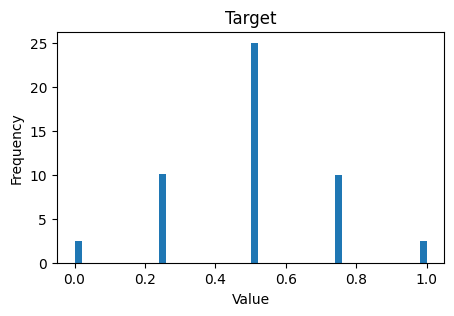

In [9]:
# Plot density histogram of the target
train["target"].plot(
  kind="hist",
  title="Target",
  figsize=(5, 3),
  xlabel="Value",
  density=True,
  bins=50
)

### Features


<Axes: title={'center': 'missing data'}, ylabel='Frequency'>

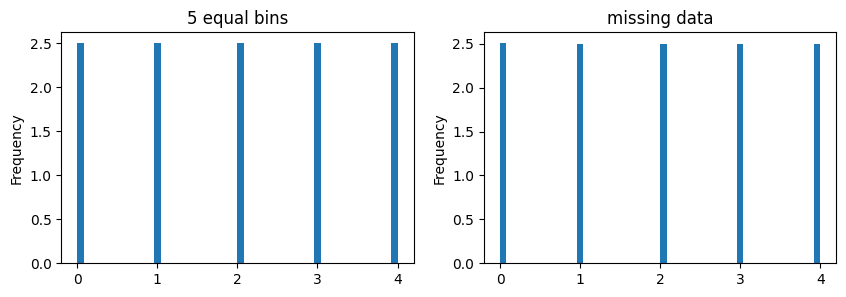

In [10]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
first_era = train[train["era"] == train["era"].unique()[0]]
last_era = train[train["era"] == train["era"].unique()[-1]]
last_era[feature_set[-1]].plot(
   title="5 equal bins",
   kind="hist",
   density=True,
   bins=50,
   ax=ax1
)
first_era[feature_set[-1]].plot(
   title="missing data",
   kind="hist",
   density=True,
   bins=50,
   ax=ax2
)

## 2. Modeling


### Model training



In [ ]:
# 2. Modeling — ensemble avanzato (versione ottimizzata per Colab)

import gc
import lightgbm as lgb
from sklearn.decomposition import PCA
from numerai_tools.scoring import numerai_corr
from typing import List, Tuple

def make_era_splits(eras: np.ndarray,
                    n_splits: int = 4,
                    embargo_eras: int = 4) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Crea splits walk-forward per era con embargo.
    """
    eras = np.sort(np.unique(eras))
    n_eras = len(eras)
    split_size = n_eras // (n_splits + 1)
    splits = []
    for i in range(n_splits):
        train_end = split_size * (i + 1)
        val_start = train_end + embargo_eras
        val_end = min(val_start + split_size, n_eras)
        if val_start >= n_eras or val_start >= val_end:
            break
        train_eras = eras[:train_end]
        val_eras = eras[val_start:val_end]
        splits.append((train_eras, val_eras))
    return splits

def eras_to_index(df: pd.DataFrame, train_eras, val_eras):
    train_idx = df.index[df["era"].isin(train_eras)].values
    val_idx = df.index[df["era"].isin(val_eras)].values
    return train_idx, val_idx

def neutralize_series(series: pd.Series,
                      exposures: np.ndarray,
                      proportion: float = 1.0) -> pd.Series:
    """
    Neutralizza le previsioni rispetto alle componenti principali (PCA) delle feature.
    """
    s = series.values.reshape(-1, 1)
    x = exposures
    x = x / (np.sqrt((x ** 2).sum(axis=0, keepdims=True)) + 1e-8)

    correction = x @ np.linalg.pinv(x).dot(s)
    neutralized = s - proportion * correction
    neutralized = neutralized.ravel()
    neutralized = (neutralized - neutralized.mean()) / (neutralized.std() + 1e-8)
    return pd.Series(neutralized, index=series.index)

def to_rank(preds: pd.Series) -> pd.Series:
    """
    Converte in rank normalizzato (molto importante per Numerai).
    """
    return preds.rank(method="first").values / (len(preds) + 1) - 0.5

class NumeraiEnsembleModel:
    def __init__(self,
                 feature_cols,
                 target_cols,
                 n_splits: int = 4,
                 embargo_eras: int = 4):
        self.feature_cols = feature_cols
        self.target_cols = target_cols
        self.n_splits = n_splits
        self.embargo_eras = embargo_eras

        self.models = {t: [] for t in target_cols}
        self.target_weights = {t: 1.0 for t in target_cols}
        self.pca = None
        self.per_era_corr = {}

    def _lgb_params(self):
        """
        Parametri un po' più leggeri ma comunque aggressivi.
        Puoi pomparli quando non sei su Colab free.
        """
        return dict(
            objective="regression",
            n_estimators=4096,
            learning_rate=0.02,
            max_depth=8,
            num_leaves=255,
            colsample_bytree=0.2,
            min_data_in_leaf=5000,
            subsample=0.7,
            subsample_freq=1,
            n_jobs=-1
        )

    def fit(self, train: pd.DataFrame):
        eras = train["era"].values
        splits = make_era_splits(
            eras,
            n_splits=self.n_splits,
            embargo_eras=self.embargo_eras
        )

        # --- PCA su un campione per non ammazzare la RAM ---
        pca_sample = train[self.feature_cols].sample(
            n=min(300_000, len(train)),
            random_state=42
        )
        self.pca = PCA(n_components=min(8, len(self.feature_cols)), random_state=42)
        self.pca.fit(pca_sample.values)

        # Out-of-fold predictions per target (per pesare i target)
        self.oof_preds = {t: pd.Series(0.0, index=train.index) for t in self.target_cols}
        self.oof_counts = {t: pd.Series(0.0, index=train.index) for t in self.target_cols}
        self.per_era_corr = {t: None for t in self.target_cols}

        for split_id, (train_eras, val_eras) in enumerate(splits):
            print(f"=== Split {split_id+1}/{len(splits)} ===")
            tr_idx, val_idx = eras_to_index(train, train_eras, val_eras)

            X_tr = train.loc[tr_idx, self.feature_cols].astype("float32")
            X_val = train.loc[val_idx, self.feature_cols].astype("float32")

            expo_val = self.pca.transform(X_val.values)

            for target in self.target_cols:
                y_tr = train.loc[tr_idx, target].astype("float32")
                y_val = train.loc[val_idx, target].astype("float32")

                model = lgb.LGBMRegressor(**self._lgb_params())
                model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    eval_metric="l2",
                    callbacks=[
                        lgb.early_stopping(stopping_rounds=100, verbose=False)
                    ]
                )

                self.models[target].append(model)

                val_raw = pd.Series(model.predict(X_val), index=train.loc[val_idx].index)
                val_neut = neutralize_series(val_raw, expo_val, proportion=1.0)
                val_pred = to_rank(val_neut)

                self.oof_preds[target].loc[val_idx] += val_pred
                self.oof_counts[target].loc[val_idx] += 1.0

            # libera RAM a ogni split
            del X_tr, X_val, expo_val, y_tr, y_val
            gc.collect()

        # media OOF per ogni target
        for t in self.target_cols:
            mask = self.oof_counts[t] > 0
            self.oof_preds[t].loc[mask] /= self.oof_counts[t].loc[mask]

        # calcolo sharpe per target, da usare come peso
        for t in self.target_cols:
            print(f"\n### Valutazione target {t} (OOF) ###")
            df_tmp = train[["era", t]].copy()
            df_tmp["prediction"] = self.oof_preds[t]
            df_tmp = df_tmp.dropna(subset=["prediction", t])

            per_era_corr = df_tmp.groupby("era").apply(
                lambda x: numerai_corr(x[["prediction"]], x[t])
            )

            # numerai_corr può restituire Series: convertiamo in float
            if isinstance(per_era_corr.iloc[0], pd.Series):
                per_era_corr_vals = per_era_corr.apply(lambda s: float(s.values[0]))
            else:
                per_era_corr_vals = per_era_corr.astype(float)

            self.per_era_corr[t] = per_era_corr_vals

            mean_corr = per_era_corr_vals.mean()
            std_corr = per_era_corr_vals.std(ddof=0)
            sharpe = mean_corr / (std_corr + 1e-8)

            print(f"mean CORR:   {mean_corr:.5f}")
            print(f"std CORR:    {std_corr:.5f}")
            print(f"Sharpe:      {sharpe:.3f}")

            self.target_weights[t] = max(sharpe, 0.0)

        # normalizziamo i pesi per i target
        total_w = sum(self.target_weights.values())
        if total_w <= 0:
            self.target_weights = {t: 1.0 for t in self.target_cols}
            total_w = float(len(self.target_cols))
        for t in self.target_cols:
            self.target_weights[t] /= total_w

        print("\nPesi finali dei target nel meta-ensemble:")
        for t, w in self.target_weights.items():
            print(f"{t}: {w:.3f}")

    def _predict_single_target(self, df: pd.DataFrame, target: str) -> pd.Series:
        X = df[self.feature_cols].astype("float32")
        expo = self.pca.transform(X.values)
        preds_raw = np.mean([m.predict(X) for m in self.models[target]], axis=0)
        s_raw = pd.Series(preds_raw, index=df.index)
        s_neut = neutralize_series(s_raw, expo, proportion=1.0)
        s_rank = to_rank(s_neut)
        return s_rank

    def predict(self, df: pd.DataFrame) -> pd.Series:
        target_preds = {}
        for t in self.target_cols:
            target_preds[t] = self._predict_single_target(df, t)

        final = None
        for t, s in target_preds.items():
            w = self.target_weights.get(t, 1.0 / len(self.target_cols))
            if final is None:
                final = w * s
            else:
                final += w * s

        return final

# allena il modello ensemble sul train
ensemble_model = NumeraiEnsembleModel(
    feature_cols=feature_set,
    target_cols=target_cols,
    n_splits=4,     # tienilo basso su Colab; puoi portarlo a 6–8 più avanti
    embargo_eras=4
)

ensemble_model.fit(train)


### Validation predictions


In [ ]:
# Validation predictions con ensemble

napi.download_dataset(f"{DATA_VERSION}/validation.parquet")

validation = pd.read_parquet(
    f"{DATA_VERSION}/validation.parquet",
    columns=["era", "data_type"] + target_cols + feature_set
)
validation = validation[validation["data_type"] == "validation"].copy()
del validation["data_type"]

# (opzionale) downsample per test veloce
# validation = validation[validation["era"].isin(validation["era"].unique()[::2])]

# embargo iniziale come nell'hello world
last_train_era = int(train["era"].unique()[-1])
eras_to_embargo = [str(era).zfill(4) for era in [last_train_era + i for i in range(4)]]
validation = validation[~validation["era"].isin(eras_to_embargo)]

# prediction con ensemble
validation["prediction"] = ensemble_model.predict(validation)

validation[["era", "prediction", "target"]]


### Performance evaluation


In [ ]:
# Performance evaluation con ensemble (CORR + MMC)

from numerai_tools.scoring import numerai_corr, correlation_contribution

# scarica meta_model per le ere di validation
napi.download_dataset(f"v4.3/meta_model.parquet", round_num=842)
meta_model = pd.read_parquet("v4.3/meta_model.parquet")["numerai_meta_model"]
validation["meta_model"] = meta_model.reindex(validation.index)

# CORR per era
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# MMC per era
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(
        x[["prediction"]],
        x["meta_model"],
        x["target"]
    )
)

# convertiamo in float se necessario
if isinstance(per_era_corr.iloc[0], pd.Series):
    per_era_corr_vals = per_era_corr.apply(lambda s: float(s.values[0]))
    per_era_mmc_vals = per_era_mmc.apply(lambda s: float(s.values[0]))
else:
    per_era_corr_vals = per_era_corr.astype(float)
    per_era_mmc_vals = per_era_mmc.astype(float)

# Plot
per_era_corr_vals.plot(
    title="Validation CORR (ensemble)",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False
)
per_era_mmc_vals.plot(
    title="Validation MMC (ensemble)",
    kind="bar",
    figsize=(8, 4),
    xticks=[],
    legend=False
)

# metriche riassuntive
def summarize(series: pd.Series):
    mean = series.mean()
    std = series.std(ddof=0)
    sharpe = mean / (std + 1e-8)
    mdd = (series.cumsum().expanding(min_periods=1).max() - series.cumsum()).max()
    return mean, std, sharpe, mdd

corr_mean, corr_std, corr_sharpe, corr_mdd = summarize(per_era_corr_vals)
mmc_mean, mmc_std, mmc_sharpe, mmc_mdd = summarize(per_era_mmc_vals)

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_mdd, mmc_mdd]
}, index=["CORR", "MMC"])


In [ ]:
# Compute the per-era corr between our predictions and the target values
per_era_corr = validation.groupby("era").apply(
    lambda x: numerai_corr(x[["prediction"]].dropna(), x["target"].dropna())
)

# Compute the per-era mmc between our predictions, the meta model, and the target values
per_era_mmc = validation.dropna().groupby("era").apply(
    lambda x: correlation_contribution(x[["prediction"]], x["meta_model"], x["target"])
)


# Plot the per-era correlation
per_era_corr.plot(
  title="Validation CORR",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)
per_era_mmc.plot(
  title="Validation MMC",
  kind="bar",
  figsize=(8, 4),
  xticks=[],
  legend=False,
  snap=False
)

In [ ]:
# Plot the cumulative per-era correlation
per_era_corr.cumsum().plot(
  title="Cumulative Validation CORR",
  kind="line",
  figsize=(8, 4),
  legend=False
)
per_era_mmc.cumsum().plot(
  title="Cumulative Validation MMC",
  kind="line",
  figsize=(8, 4),
  legend=False
)

### Performance metrics



In [ ]:
# Compute performance metrics
corr_mean = per_era_corr.mean()
corr_std = per_era_corr.std(ddof=0)
corr_sharpe = corr_mean / corr_std
corr_max_drawdown = (per_era_corr.cumsum().expanding(min_periods=1).max() - per_era_corr.cumsum()).max()

mmc_mean = per_era_mmc.mean()
mmc_std = per_era_mmc.std(ddof=0)
mmc_sharpe = mmc_mean / mmc_std
mmc_max_drawdown = (per_era_mmc.cumsum().expanding(min_periods=1).max() - per_era_mmc.cumsum()).max()

pd.DataFrame({
    "mean": [corr_mean, mmc_mean],
    "std": [corr_std, mmc_std],
    "sharpe": [corr_sharpe, mmc_sharpe],
    "max_drawdown": [corr_max_drawdown, mmc_max_drawdown]
}, index=["CORR", "MMC"]).T

## 3. Submissions



In [ ]:
# 3. Submissions — live predictions con ensemble

napi.download_dataset(f"{DATA_VERSION}/live.parquet")

live_features = pd.read_parquet(
    f"{DATA_VERSION}/live.parquet",
    columns=feature_set
)

live_predictions = ensemble_model.predict(live_features)
live_submission = live_predictions.to_frame("prediction")
live_submission


### Model upload



In [ ]:
# Model upload — usa ensemble_model invece del modello semplice

import cloudpickle
import pandas as pd  # per sicurezza nel runtime Numerai

def predict(live_features: pd.DataFrame,
            _live_benchmark_models: pd.DataFrame) -> pd.DataFrame:
    """
    Funzione che Numerai chiamerà per generare le live predictions.
    Usa l'ensemble già addestrato.
    """
    preds = ensemble_model.predict(live_features)
    return preds.to_frame("prediction")

with open("numerai_ensemble_sota.pkl", "wb") as f:
    cloudpickle.dump(predict, f)

try:
    from google.colab import files
    files.download("numerai_ensemble_sota.pkl")
except:
    pass
